In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.cluster import DBSCAN
from sklearn.metrics.pairwise import haversine_distances

In [12]:
def get_centeroid(cluster):
	lon, lat = 0, 0
	for row in cluster.itertuples(index=False):
		lat += row.lat
		lon += row.lon
	return [lat / len(cluster), lon / len(cluster)] # [longitude, latitude]

In [13]:
def _dbscan(df, eps_rad, msp, filter_speed=True):
	# filter the speed
	if filter_speed:
		df = df[df['speed'] <= 1]
	df = df.sample(frac=1 if len(df) <= 48000 else 48000/len(df))
	if len(df) == 0:
		return None

	
	coords = df[['lat', 'lon']]
	db = DBSCAN(eps=eps_rad, min_samples=msp, algorithm='ball_tree', metric='haversine', n_jobs=12).fit(np.radians(coords))
	cluster_lables = db.labels_
	n_clusters = len(set(cluster_lables)) - (1 if -1 in cluster_lables else 0)
	n_noise_ = list(cluster_lables).count(-1)
	if n_clusters == 0:
		return None

	clusters = pd.Series([coords[cluster_lables == n] for n in range(n_clusters)])
	centers = clusters.map(get_centeroid).tolist()
	return centers

In [14]:
def closest_node(node, nodes):
	closest_index, dist = -1, 1e12
	for i in range(len(nodes)):
		curdis = haversine_distances(np.radians([node]), np.radians([nodes[i]]))[0][0] * 6371
		if curdis < dist:
			dist, closest_index = curdis, i

	# if dist < 50:
	# 	print("{}\t{},{}\t{},{}".format(dist, node[0], node[1], nodes[closest_index][0], nodes[closest_index][1]))
	return closest_index if dist < 15 else -1

In [15]:
data = pd.read_csv('solved.csv', delim_whitespace=True)
data['geohash'] = pd.to_numeric(data['geohash'])
print(data.info())

dflist = [[] for _ in range(256)]
for row in data.itertuples(index=False):
    dflist[row.geohash >> 56].append(row)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7896919 entries, 0 to 7896918
Data columns (total 8 columns):
 #   Column     Dtype  
---  ------     -----  
 0   mmsi       int64  
 1   timestamp  int64  
 2   speed      int64  
 3   status     int64  
 4   lon        float64
 5   lat        float64
 6   draught    float64
 7   geohash    uint64 
dtypes: float64(3), int64(4), uint64(1)
memory usage: 482.0 MB
None


In [16]:
colNames = ['mmsi', 'timestamp', 'status', 'speed', 'lon', 'lat', 'draught', 'geohash']
kms_per_radian = 6371.
# eps_rad = 5 / kms_per_radian
eps_rad = 1 / kms_per_radian
centers = []
for i in range(256):
    df = pd.DataFrame.from_records(dflist[i], columns=colNames)
    # res = _dbscan(df, eps_rad, 500)
    res = _dbscan(df, eps_rad, 250)
    print("---Block {} finished---".format(i))
    if res is None:
        continue
    centers.extend(res)

---Block 0 finished---
---Block 1 finished---
---Block 2 finished---
---Block 3 finished---
---Block 4 finished---
---Block 5 finished---
---Block 6 finished---
---Block 7 finished---
---Block 8 finished---
---Block 9 finished---
---Block 10 finished---
---Block 11 finished---
---Block 12 finished---
---Block 13 finished---
---Block 14 finished---
---Block 15 finished---
---Block 16 finished---
---Block 17 finished---
---Block 18 finished---
---Block 19 finished---
---Block 20 finished---
---Block 21 finished---
---Block 22 finished---
---Block 23 finished---
---Block 24 finished---
---Block 25 finished---
---Block 26 finished---
---Block 27 finished---
---Block 28 finished---
---Block 29 finished---
---Block 30 finished---
---Block 31 finished---
---Block 32 finished---
---Block 33 finished---
---Block 34 finished---
---Block 35 finished---
---Block 36 finished---
---Block 37 finished---
---Block 38 finished---
---Block 39 finished---
---Block 40 finished---
---Block 41 finished---
--

In [17]:
centers = pd.DataFrame(centers, columns=['lat', 'lon'])
result = _dbscan(centers, 5/kms_per_radian, 1, False)

prev, flg = None, 0
incls, total = 0, 0
stat = [0 for _ in range(len(result))]
for row in data.itertuples(index=False):
    if flg == 0:
        flg += 1
    elif abs(row.draught - prev.draught) > 1 and row.mmsi == prev.mmsi:
        # cls = closest_node([data.iloc[i].lat, data.iloc[i].lon], [[-89, 179], [0, 0], [12, 34], [56, 78]])
        cls = closest_node([row.lat, row.lon], result)
        total += 1
        incls += 1 if cls != -1 else 0
        # stat[cls] += 1
        stat[cls] += 1 if row.draught > prev.draught else -1

    prev = row

In [18]:
print(len(result))
print(incls / total * 100)
print(stat)
lngs = [result[i] for i, e in enumerate(stat) if abs(e) > 3]
print(len(lngs))
print(lngs)

372
89.63754646840148
[-31, -14, -21, 6, 76, -26, 0, -1, -7, 9, -14, 0, -21, -18, 0, -1, -71, -15, -21, -53, -42, -38, 4, -24, -6, 1, 0, 0, -3, 0, -20, 114, 0, -62, -1, 3, -1, -23, -9, 1, -1, -7, 3, -3, 0, 12, 4, -20, 2, -3, -34, -2, 0, -2, -2, -13, -17, -14, -18, -3, 5, -3, 0, 0, -7, -1, 0, 0, 0, -17, -5, 1, -14, 1, -21, 0, 0, -39, -8, -1, -1, -1, 50, 0, -2, -7, 0, -8, -40, 0, -4, -1, -74, 0, 0, -3, -1, 145, -17, 8, -7, -15, 0, 3, -23, 10, 0, -13, 0, -13, 1, 2, 0, -73, 0, -2, 5, -3, -16, -2, -2, -1, -13, 0, -49, -2, -1, -1, -14, -7, -2, -5, -12, -9, -23, -23, -11, -1, -1, -14, 0, -13, -1, -21, -1, -2, -22, -21, -9, 2, -5, -1, -1, -2, -2, 24, -6, 2, -62, 0, 3, -29, -5, -27, 16, 0, -3, -31, -12, -16, -6, -6, 0, -11, -3, -4, -2, -8, 0, -2, -1, -6, -5, -2, -10, 0, -7, 2, -11, 0, -1, 0, -2, 2, -4, -24, 0, 7, -1, 10, 68, 1, 1, -17, -1, -16, -6, -2, 1, -13, 3, -3, -2, -2, 10, -2, 0, -1, -7, -2, 6, -2, 2, 0, -2, 65, 0, -15, 2, -2, -24, -41, 2, 4, 0, -1, -3, 0, -23, 0, 9, 3, 0, 1, 0, 34, -5, -

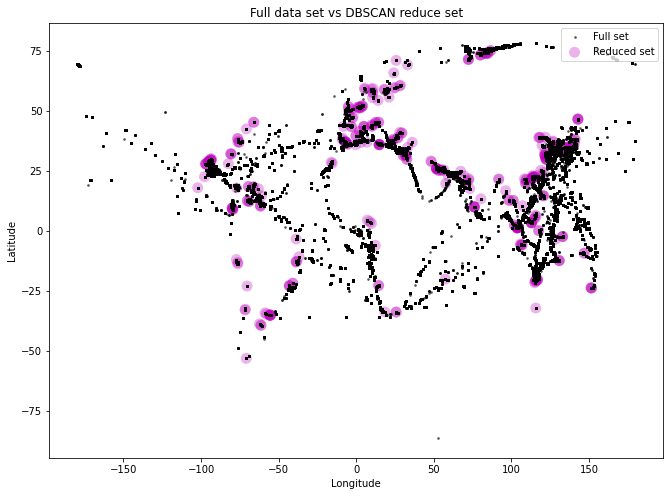

In [19]:
result = pd.DataFrame(result, columns=['lat', 'lon'])
fig, ax = plt.subplots(figsize=[11, 8])
rs_scatter = ax.scatter(result['lon'], result['lat'], c='m', edgecolor='None', alpha=0.3, s=120)
df_scatter = ax.scatter(data['lon'], data['lat'], c='k', alpha=0.5, s=3)
ax.set_title('Full data set vs DBSCAN reduce set')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend([df_scatter, rs_scatter], ['Full set', 'Reduced set'], loc='upper right')
plt.show()

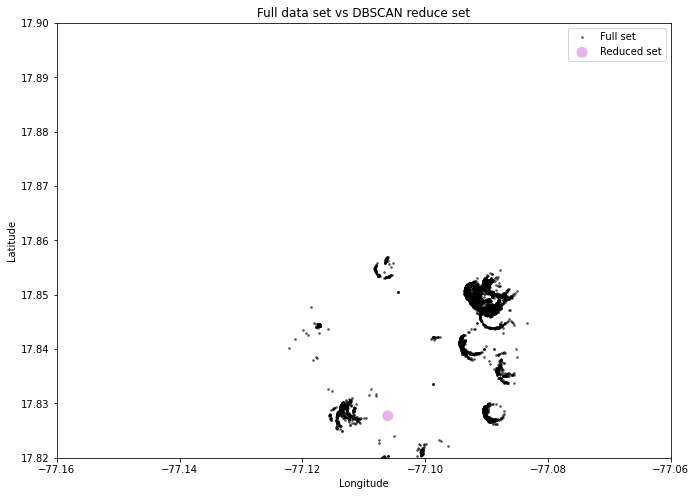

In [20]:
fig, ax = plt.subplots(figsize=[11, 8])
rs_scatter = ax.scatter(result['lon'], result['lat'], c='m', edgecolor='None', alpha=0.3, s=120)
df_scatter = ax.scatter(data['lon'], data['lat'], c='k', alpha=0.5, s=3)
ax.set_title('Full data set vs DBSCAN reduce set')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_xlim([-77.16, -77.06])
ax.set_ylim([17.82, 17.90])
ax.legend([df_scatter, rs_scatter], ['Full set', 'Reduced set'], loc='upper right')
plt.show()